In [1]:
#importing everything required
import random
import pickle
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)


In [2]:
def load_data():
    data = np.array(pd.read_csv('data.csv'))
    np.random.shuffle(data)

    train_data = data[0:60000].T
    nx = train_data.shape[1]
    train_X = train_data[1:nx]
    train_X = train_X/255.0
    train_Y = train_data[0]

    test_data = data[60000:70000].T
    nx = test_data.shape[1]
    test_X = test_data[1:nx]
    test_X = test_X/255.0
    test_Y = test_data[0]

    return train_X, train_Y, test_X, test_Y

In [3]:
train_X, train_Y , test_X, test_Y = load_data()
print("train_X data shape: ", train_X.shape)
print("train_Y data shape: ", train_Y.shape)
print("test_X data shape: ", test_X.shape)
print("test_Y data shape: ", test_Y.shape)

train_X data shape:  (784, 60000)
train_Y data shape:  (60000,)
test_X data shape:  (784, 10000)
test_Y data shape:  (10000,)


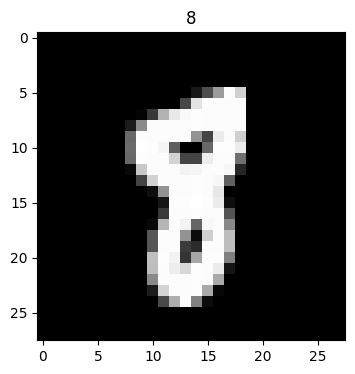

In [4]:
#showing sample image along with their label

index = 4528
temp = np.reshape(train_X.T[index], (28,28))
plt.imshow(temp, cmap='gray')
plt.title(str(train_Y[index]))
plt.show()

In [5]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A, Z
#print(sigmoid(0.5))

def sigmoid_prime(Z):
    s = sigmoid(Z)
    dZ = s*(1-s)
    return dZ

In [6]:
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    return A, Z

def relu_prime(Z):
    return Z>0

In [7]:
def softmax(Z):
    A = np.exp(Z)/sum(np.exp(Z))
    return A, Z

In [8]:
#size of train and test set and also each pixel value

m_train = train_X.shape[1]
num_px = train_X.shape[0]
m_test = test_X.shape[1]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size:", num_px, "pixels")


Number of training examples: 60000
Number of testing examples: 10000
Each image is of size: 784 pixels


In [9]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

#print(initialize_parameters_deep([2, 4, 5, 4, 2]))

In [10]:
def normalize(Y):
    normalized_Y = np.zeros((Y.size, 10))
    normalized_Y[np.arange(Y.size), Y] = 1
    normalized_Y = normalized_Y.T
    return normalized_Y

In [11]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [12]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

In [13]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)] , "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)] , "softmax")
    caches.append(cache)    
          
    return AL, caches


In [14]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = dA*relu_prime(activation_cache)
    elif activation == "sigmoid":
        dZ = dA*sigmoid_prime(activation_cache)
    elif activation == "sum_sqr":
        dZ = dA
    
    dA_prev, dW, db =  linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [16]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = normalize(Y)
    dAL = AL-Y
    current_cache = caches[L-1]
    grads["dA"+str(L-1)], grads["dW"+str(L)], grads["db"+str(L)] = linear_activation_backward(dAL, current_cache, "sum_sqr")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads["dA"+str(l)], grads["dW"+str(l+1)], grads["db"+str(l+1)] = linear_activation_backward(grads["dA"+str(l+1)], current_cache, "relu")

    return grads

In [17]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db"+str(l+1)]

    return parameters

In [18]:
def compute_cost(A, Y):
    return 0.5*(np.linalg.norm(Y-A)**2)/Y.size

def compute_accuracy(A, Y):
    return (np.sum(A==Y)*100)/Y.size


In [19]:
def predict(A):
    return np.argmax(A,0)

In [22]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10 == 0 or i == num_iterations - 1:
            predictions = predict(AL)
            cost = compute_cost(predictions,Y)
            print("Accuracy after iteration", i,": ", compute_accuracy(predictions,Y), "%")
            print("Cost after iteration", i,": ", cost)
    
    return parameters

In [23]:
layers_dims = [28*28, 16, 10] 
parameters = L_layer_model(train_X, train_Y, layers_dims, num_iterations = 1000, print_cost = True)

Accuracy after iteration 0 :  7.906666666666666 %
Cost after iteration 0 :  10.6213
Accuracy after iteration 10 :  15.451666666666666 %
Cost after iteration 10 :  9.974808333333335
Accuracy after iteration 20 :  20.48 %
Cost after iteration 20 :  10.111108333333332
Accuracy after iteration 30 :  28.273333333333333 %
Cost after iteration 30 :  8.997283333333334
Accuracy after iteration 40 :  32.49333333333333 %
Cost after iteration 40 :  8.242583333333334
Accuracy after iteration 50 :  34.79666666666667 %
Cost after iteration 50 :  8.1083
Accuracy after iteration 60 :  38.836666666666666 %
Cost after iteration 60 :  7.199066666666667
Accuracy after iteration 70 :  46.233333333333334 %
Cost after iteration 70 :  5.667233333333333
Accuracy after iteration 80 :  55.39 %
Cost after iteration 80 :  4.316158333333333
Accuracy after iteration 90 :  61.32 %
Cost after iteration 90 :  3.482966666666667
Accuracy after iteration 100 :  65.22166666666666 %
Cost after iteration 100 :  2.947033333333

In [24]:
def test(X, parameters):
    A,_ = L_model_forward(X, parameters)
    predictions = predict(A)
    return predictions

Y_hat = test(train_X, parameters)
accuracy = compute_accuracy(Y_hat, train_Y)
print("Accuracy over train set: ", accuracy)

Y_hat = test(test_X, parameters)
accuracy = compute_accuracy(Y_hat, test_Y)
print("Accuracy over train set: ", accuracy)


Accuracy over train set:  91.67166666666667
Accuracy over train set:  92.02


In [25]:
def visual(index):
    tmp = train_X[:, index]
    image = tmp.reshape((28, 28)) * 255
    plt.imshow(image)
    plt.title("Index: "+str(index)+"\n"+str(train_Y[index]))
    plt.show()

    prediction = test(train_X[:, index, None], parameters)
    print("Result: ", prediction)


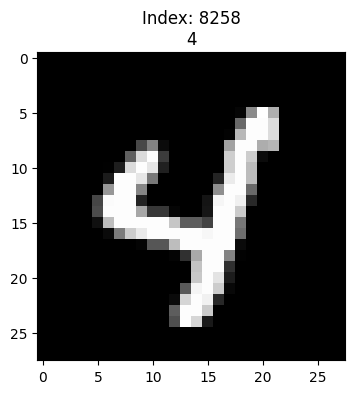

Result:  [4]


In [27]:
visual(index = random.randint(0,9999))